In [1]:
import os
import sys
import numpy as np
from pathlib import Path
from time import time
import pickle
import logging
from astropy.table import Table
import orpheus
from matplotlib import pyplot as plt

np.set_printoptions(suppress=True)

# Load data

Here we use a mock catalog from the SLICS ensemble

In [2]:
dotomo=True
data = Table.read("/cosma7/data/dp004/dc-port3/Data/SLICS/KiDS450/GalCatalog_LOS1.fits")
pos1 = data["x_arcmin"].data
pos2 = data["y_arcmin"].data
gamma1 = data["shear1"].data
gamma2 = data["shear2"].data
e1 = data["eps_obs1"].data
e2 = data["eps_obs2"].data
zspec = data["z_spectroscopic"].data
zphot = data["z_photometric"].data
zbin = np.zeros(len(pos1),dtype=np.int32)
if dotomo:
    zbin[zphot<=0.25] = 0 
    zbin[(zphot>0.25)*(zphot<=0.5)] = 1
    zbin[(zphot>0.5)*(zphot<=0.75)] = 2
    zbin[(zphot>0.75)*(zphot<=1.)] = 3
    zbin[zphot>1.] = 4

In [3]:
slicsfullreso = orpheus.SpinTracerCatalog(spin=2, pos1=pos1, pos2=pos2, tracer_1=gamma1, tracer_2=gamma2, zbins=zbin)
print("We have %i galaxies in the mock catalog"%slicsfullreso.ngal)

We have 3070801 galaxies in the mock catalog


# Create the multireso catalog

Here we need to choose the gridsizes onto which the mock catalog is mapped.

In [4]:
dpixs = [0.2*i for i in [1,2,4,8,16,32]]
print(dpixs)

[0.2, 0.4, 0.8, 1.6, 3.2, 6.4]


Now let us create all the reduced catalogs including the various pixel-mappings between them. Note that here we flatten the outputs, as this is also what is getting passed to the C-library. The outputted quantities correspond to the following:
* `ngals`: Array of shape (nresos, ) <br> 
The number of galaxies for each of the catalogs. We start from the discrete catalog and then go to more and more reduced catalogs
* `resos1`: Array of shape (nresos, ) <br> 
The x-sidelength of the pixelgrid that defines each of the reduced catalogs. Per default, the zeroth element (corresponding to the full catalog) is set to zero.
* `resos2`: Array of shape (nresos, ) <br> 
Same as resos1, but the y-sidelength. Usually the same as `resos1`
* `ngalshifts_1d`: Array of shape (nresos+1, ) <br>
A helper array with shift indices for enumerating through the flattened position, weight, ... arrays of the set of reduced catalogs. 
* `ngalshifts_3d`: Flattened array constructed from array of shape (nresos+1, nresos) <br>
A helper array with shift indices for enumerating through the `pixmatcher` array. 
* `pos1s`: Array of shape (sum(`ngals`), ) <br> 
The x-position of the tracers in all the reduced catalogs. The first `ngals[0]` elements belong to the discrete catalog, and so on.
* `pos2s`,`weights`,`zbins`,: Arrays of shape (sum(`ngals`), ) <br> 
Same as `pos1s`, but corresponding to the y-positions, the weights, and the photo-z bins of the tracers.
* `allfields` list corresponding to the number of fields of the child class of `Catalog`. Each element of the list has shape (sum(`ngals`), ) <br>
Same as `pos1`, but for each component of the field of the tracers
* `index_matchers`: Flattened array constructed from array of shape (nresos, hash_npix_1, hash_npix_2) <br>
Matches the `index_matcher` variable of the `_multihash` method.
* `pixs_galind_bounds`: Flattened array constructed from array of shape sum(`ngals`+1) <br>
Matches the `pixs_galind_bounds` variable of the `_multihash` method.
* `pix_gals`: Flattened array constructed from array of shape sum(`ngals`) <br>
Matches the `pix_gals` variable of the `_multihash` method.
* `pixmatcher`: Array of shape (sum_i (nresos-1-i)*ngals[i]) ,) <br>
Matches the index `i1` of a galaxy in resolution `elreso1` to index of a courser catalog of resolution `elreso2`

In [6]:
_ = slicsfullreso.genmatched_multiresocats(dpixs,flattened=True)
ngals, resos1, resos2, ngalshifts_1d, ngalshifts_3d, \
pos1s, pos2s, weights, zbins, allfields, \
index_matchers, pixs_galind_bounds, pix_gals, pixmatcher = _
nresos = len(ngals)

# Investigate the multireso catalogs

Let us first see how many galaxies are in each of the reduced catalogs - this level of reduction gives a quadratic reduction for the computation of the Gns and a linear one in the allocation of the Gamma_ns.

In [7]:
print("Number of galaxies:")
print(ngals)
print("Reduction factor:")
print(np.round(slicsfullreso.ngal/ngals,2))

Number of galaxies:
[3070801 2948514 2623169 1749281  662421  176626   44180]
Reduction factor:
[ 1.    1.04  1.17  1.76  4.64 17.39 69.51]


While we always assume the pixels to be quadratic, their size might marginally change given the footprint of the mock. We also set by default the zeroth element of the pixel resolution to zero, indicating that this corresponds to the complete discrete catalog.

In [8]:
print(dpixs)
print(resos1)
print(resos2)

[0.2, 0.4, 0.8, 1.6, 3.2, 6.4]
[0.         0.19999998 0.39999996 0.79999992 1.59999984 3.19999968
 6.39999935]
[0.         0.19999998 0.39999996 0.79999992 1.59999984 3.19999968
 6.39999935]


As an example, let us plot a reduced catalog for some resolution scale. We can see that the points need not to lie in the pixel center, but as we average all locations for sufficiently large pixels the mean location will converge to the pixel center. Note that in this plot, the size of each dots is proportional to the total weight within this specific pixel.

Intrinsic pixel size is 1.60 x 1.60 arcmin


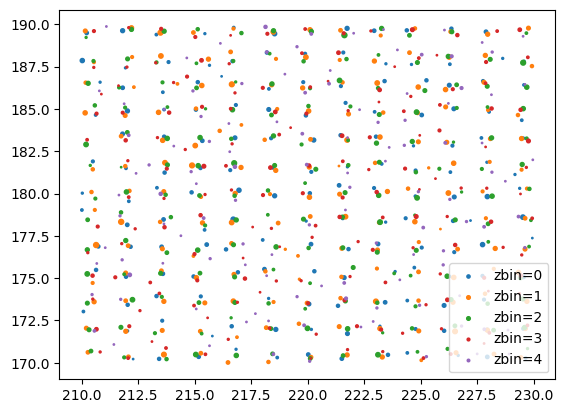

In [17]:
elreso = 4

print("Intrinsic pixel size is %.2f x %.2f arcmin"%(resos1[elreso],resos1[elreso]))
_pos1 = pos1s[ngalshifts_1d[elreso]:ngalshifts_1d[elreso+1]]
_pos2 = pos2s[ngalshifts_1d[elreso]:ngalshifts_1d[elreso+1]]
_ws = weights[ngalshifts_1d[elreso]:ngalshifts_1d[elreso+1]]
_zs = zbins[ngalshifts_1d[elreso]:ngalshifts_1d[elreso+1]]
_sel = (_pos1>210)*(_pos1<230)*(_pos2>170)*(_pos2<190)
for elbinz in range(slicsfullreso.nbinsz):
    _zsel = _sel*(_zs==elbinz)
    plt.scatter(_pos1[_zsel],
                _pos2[_zsel],s=_ws[_zsel], label="zbin=%i"%elbinz)
plt.legend()
plt.show()

Now let us see how the matcher between two reduced catalogs are working. For this, we choose the reduction scale for the first (`elreso`) and the second (`elreso2`) catalog. We then pick a the index of the galaxy of the lower resolution catalog (`pix_target`) onto which we want to match the indices of the higher resolution catalog.

In the resulting plot we again indicate the total weight of each galaxy by the size of the dot. We also print the cumulative weight of all pixels in the high-resolution catalog - by construction those two numbers are equal to each other.  

In [16]:
print(ngalshifts_3d.reshape((slicsfullreso.nbinsz,nresos-1,nresos)))

[[[       0   652368  1304736  1957104  2609472  3261840  3914208]
  [      -1  3914208  4543253  5172298  5801343  6430388  7059433]
  [      -1       -1  7059433  7625574  8191715  8757856  9323997]
  [      -1       -1       -1  9323997  9709815 10095633 10481451]
  [      -1       -1       -1       -1 10481451 10620726 10760001]
  [      -1       -1       -1       -1       -1 10760001 10795345]]

 [[10795345 11745911 12696477 13647043 14597609 15548175 16498741]
  [      -1 16498741 17400589 18302437 19204285 20106133 21007981]
  [      -1       -1 21007981 21782962 22557943 23332924 24107905]
  [      -1       -1       -1 24107905 24566381 25024857 25483333]
  [      -1       -1       -1       -1 25483333 25623799 25764265]
  [      -1       -1       -1       -1       -1 25764265 25799609]]

 [[25799609 26643795 27487981 28332167 29176353 30020539 30864725]
  [      -1 30864725 31670455 32476185 33281915 34087645 34893375]
  [      -1       -1 34893375 35597128 36300881 37004634 3

In [11]:
#plt.plot(pixmatcher)
#plt.plot(pixmatcher[_lower:_upper])

Doing tomographic redshift bin 0:
We match 5 galaxies of the high-res catalog to the 1223th galaxy withinn zbin 0 in the low-res catalog
The total weight of the galaxies is 5.00 (high-res) and 5.00 (low res)
Doing tomographic redshift bin 1:
We match 6 galaxies of the high-res catalog to the 1223th galaxy withinn zbin 1 in the low-res catalog
The total weight of the galaxies is 6.00 (high-res) and 6.00 (low res)
Doing tomographic redshift bin 2:
We match 5 galaxies of the high-res catalog to the 1223th galaxy withinn zbin 2 in the low-res catalog
The total weight of the galaxies is 6.00 (high-res) and 6.00 (low res)
Doing tomographic redshift bin 3:
We match 3 galaxies of the high-res catalog to the 1223th galaxy withinn zbin 3 in the low-res catalog
The total weight of the galaxies is 3.00 (high-res) and 3.00 (low res)
Doing tomographic redshift bin 4:
We match 1 galaxies of the high-res catalog to the 1223th galaxy withinn zbin 4 in the low-res catalog
The total weight of the galaxie

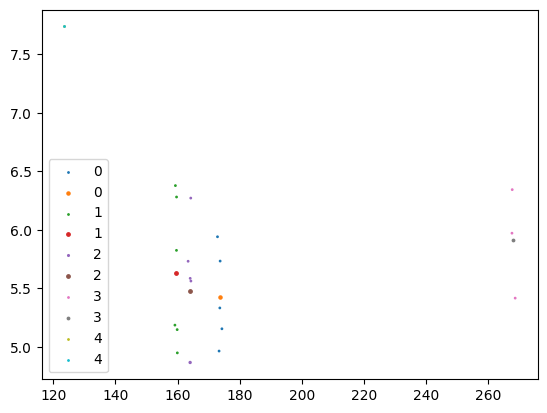

In [43]:
pix_target = 1223
elreso = 1
elreso2 = 4

for elbinz in range(slicsfullreso.nbinsz):
    _lower = ngalshifts_3d[elbinz*nresos*(nresos-1)+elreso*nresos+elreso2-1]
    _upper = ngalshifts_3d[elbinz*nresos*(nresos-1)+elreso*nresos+elreso2]
    inds_sel = np.argwhere(pixmatcher[_lower:_upper] == pix_target).flatten()
    zsel1 = zbins[ngalshifts_1d[elreso]:ngalshifts_1d[elreso+1]]==elbinz
    zsel2 = zbins[ngalshifts_1d[elreso2]:ngalshifts_1d[elreso2+1]]==elbinz
    _ws1 = weights[ngalshifts_1d[elreso]:ngalshifts_1d[elreso+1]][zsel1][inds_sel]
    _ws2 = weights[ngalshifts_1d[elreso2]:ngalshifts_1d[elreso2+1]][zsel2][pix_target]
    plt.scatter(pos1s[ngalshifts_1d[elreso]:ngalshifts_1d[elreso+1]][zsel1][inds_sel],
                pos2s[ngalshifts_1d[elreso]:ngalshifts_1d[elreso+1]][zsel1][inds_sel],
                s=_ws1, label=elbinz)
    plt.scatter(pos1s[ngalshifts_1d[elreso2]:ngalshifts_1d[elreso2+1]][zsel2][pix_target],
                pos2s[ngalshifts_1d[elreso2]:ngalshifts_1d[elreso2+1]][zsel2][pix_target],
                s=weights[ngalshifts_1d[elreso2]:ngalshifts_1d[elreso2+1]][zsel2][pix_target],label=elbinz)  
    print("Doing tomographic redshift bin %i:"%elbinz)
    print("We match %i galaxies of the high-res catalog to the %ith galaxy withinn zbin %i in the low-res catalog"%(len(inds_sel),pix_target, elbinz))
    print("The total weight of the galaxies is %.2f (high-res) and %.2f (low res)"%(np.sum(_ws1),np.sum(_ws2)))
plt.legend()
plt.show()


Doing tomographic redshift bin 0:
We match 3 galaxies of the high-res catalog to the 9223th galaxy withinn zbin 0 in the low-res catalog
The total weight of the galaxies is 3.00 (high-res) and 3.00 (low res)
Doing tomographic redshift bin 1:
We match 7 galaxies of the high-res catalog to the 9223th galaxy withinn zbin 1 in the low-res catalog
The total weight of the galaxies is 7.00 (high-res) and 7.00 (low res)
Doing tomographic redshift bin 2:
We match 5 galaxies of the high-res catalog to the 9223th galaxy withinn zbin 2 in the low-res catalog
The total weight of the galaxies is 7.00 (high-res) and 7.00 (low res)
Doing tomographic redshift bin 3:
We match 1 galaxies of the high-res catalog to the 9223th galaxy withinn zbin 3 in the low-res catalog
The total weight of the galaxies is 1.00 (high-res) and 1.00 (low res)
Doing tomographic redshift bin 4:
We match 4 galaxies of the high-res catalog to the 9223th galaxy withinn zbin 4 in the low-res catalog
The total weight of the galaxie

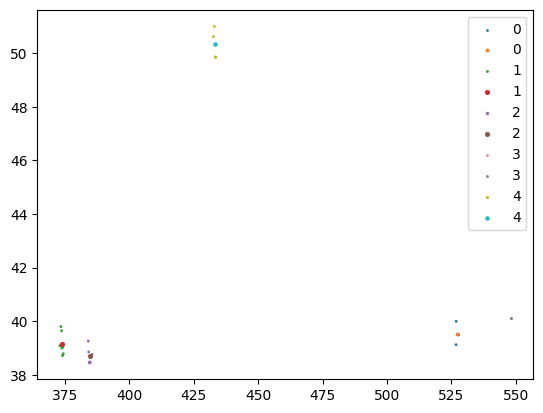

In [31]:
pix_target = 9223
elreso = 2
elreso2 = 4

for elbinz in range(slicsfullreso.nbinsz):
    _lower = ngalshifts_3d[elbinz*nresos*(nresos-1)+elreso*nresos+elreso2-1]
    _upper = ngalshifts_3d[elbinz*nresos*(nresos-1)+elreso*nresos+elreso2]
    inds_sel = np.argwhere(pixmatcher[_lower:_upper] == pix_target).flatten()
    zsel1 = zbins[ngalshifts_1d[elreso]:ngalshifts_1d[elreso+1]]==elbinz
    zsel2 = zbins[ngalshifts_1d[elreso2]:ngalshifts_1d[elreso2+1]]==elbinz
    _ws1 = weights[ngalshifts_1d[elreso]:ngalshifts_1d[elreso+1]][zsel1][inds_sel]
    _ws2 = weights[ngalshifts_1d[elreso2]:ngalshifts_1d[elreso2+1]][zsel2][pix_target]
    plt.scatter(pos1s[ngalshifts_1d[elreso]:ngalshifts_1d[elreso+1]][zsel1][inds_sel],
                pos2s[ngalshifts_1d[elreso]:ngalshifts_1d[elreso+1]][zsel1][inds_sel],
                s=_ws1, label=elbinz)
    plt.scatter(pos1s[ngalshifts_1d[elreso2]:ngalshifts_1d[elreso2+1]][zsel2][pix_target],
                pos2s[ngalshifts_1d[elreso2]:ngalshifts_1d[elreso2+1]][zsel2][pix_target],
                s=weights[ngalshifts_1d[elreso2]:ngalshifts_1d[elreso2+1]][zsel2][pix_target],label=elbinz)  
    print("Doing tomographic redshift bin %i:"%elbinz)
    print("We match %i galaxies of the high-res catalog to the %ith galaxy withinn zbin %i in the low-res catalog"%(len(inds_sel),pix_target, elbinz))
    print("The total weight of the galaxies is %.2f (high-res) and %.2f (low res)"%(np.sum(_ws1),np.sum(_ws2)))
plt.legend()
plt.show()



Note that we cannnot easily import this to the C code, as the argwhere function would introduce a lot of overhead. However, we can make use of the fact that all we practically need to do in a first step is to quickly find all the galaxies that lie in some pixel of the spatialhash. 

This is implemented in the function below, where we plot a list of pixels, in which for each pixel we loop over all resolutions up to the base resolution (on which the spatial hash is defined). In particular, note that there is no call to a for loop whatsoever.

We match 183 galaxies of the high-res catalog (resolution 0) to galaxy number 1231 in the low-res catalog
The total weight of the galaxies is 183.00 (high-res) and 68.00 (base res)
We match 178 galaxies of the high-res catalog (resolution 1) to galaxy number 1231 in the low-res catalog
The total weight of the galaxies is 183.00 (high-res) and 68.00 (base res)
We match 163 galaxies of the high-res catalog (resolution 2) to galaxy number 1231 in the low-res catalog
The total weight of the galaxies is 183.00 (high-res) and 68.00 (base res)
We match 115 galaxies of the high-res catalog (resolution 3) to galaxy number 1231 in the low-res catalog
The total weight of the galaxies is 183.00 (high-res) and 68.00 (base res)
We match 55 galaxies of the high-res catalog (resolution 4) to galaxy number 1231 in the low-res catalog
The total weight of the galaxies is 183.00 (high-res) and 68.00 (base res)
We match 19 galaxies of the high-res catalog (resolution 5) to galaxy number 1231 in the low-res

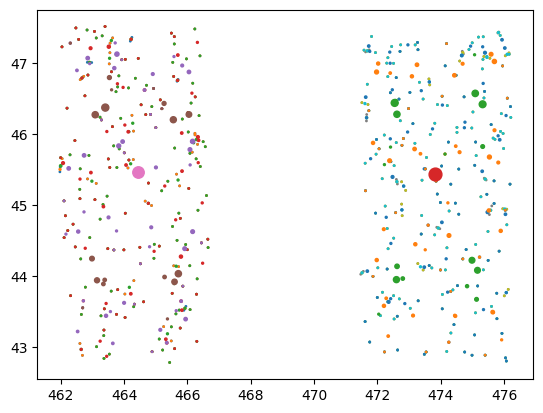

In [607]:
pix_targets = [1231,1233]
for pix_target in pix_targets:
    _wbase = weights[ngalshifts_1d[-2]:ngalshifts_1d[-1]][pix_target]
    for elreso in range(nresos-1):
        _globlower = ngalshifts_3d[elreso*nresos+(nresos-1)-1]
        ind_low = pixs_galind_bounds[ngalshifts_1d[elreso]+elreso+pix_target]
        ind_up = pixs_galind_bounds[ngalshifts_1d[elreso]+elreso+pix_target+1]
        inds_sel = pix_gals[ngalshifts_1d[elreso]+ind_low:ngalshifts_1d[elreso]+ind_up]
        _ws = weights[ngalshifts_1d[elreso]:ngalshifts_1d[elreso+1]][inds_sel]
        plt.scatter(pos1s[ngalshifts_1d[elreso]:ngalshifts_1d[elreso+1]][inds_sel],
                    pos2s[ngalshifts_1d[elreso]:ngalshifts_1d[elreso+1]][inds_sel],
                    s=_ws)
        print("We match %i galaxies of the high-res catalog (resolution %i) to galaxy number %i in the low-res catalog"%(
            len(inds_sel), elreso, pix_target))
        print("The total weight of the galaxies is %.2f (high-res) and %.2f (base res)"%(np.sum(_ws),_wbase))
    plt.scatter(pos1s[ngalshifts_1d[-2]:ngalshifts_1d[-1]][pix_target],
                pos2s[ngalshifts_1d[-2]:ngalshifts_1d[-1]][pix_target],
                s=_wbase)    
plt.show()

Finally, let us verify that we can properly loop over all the elements when allocating the hashes in the C code - for this we still need to do some more work as we need to allocate 'reduced' versions of the `pixmatcher` quantity that are conditioned on the corresponding fixed hash pixel. Here we spell out how this is done in python - the heavy lifting is done in a similar way in the C code.  

In [610]:
%%timeit

method="binary"# ["numpy","loop","binary"]


_nops = 0
pix_targets = [1352]#,12,1230,1232,2023]
cache_quantity = [None]*len(pix_targets)
pixmatcher_inpix = [None]*len(pix_targets)
pixmatcher_redpix = [None]*len(pix_targets)
for elpix_target, pix_target in enumerate(pix_targets):
    cache_quantity[elpix_target] = [None]*(nresos)
    pixmatcher_inpix[elpix_target] = [None]*nresos
    pixmatcher_redpix[elpix_target] = [None]*nresos
    for elreso in range(nresos):
        cache_quantity[elpix_target][elreso] = [None]*(nresos-elreso-1)
        pixmatcher_redpix[elpix_target][elreso] = [None]*(nresos-elreso-1)
        ind_low = pixs_galind_bounds[ngalshifts_1d[elreso]+elreso+pix_target]
        ind_up = pixs_galind_bounds[ngalshifts_1d[elreso]+elreso+pix_target+1]
        #cache_quantity[elpix_target][elreso] = np.zeros((nresos,ind_up-ind_low), dtype=np.int32)
        pixmatcher_inpix[elpix_target][elreso] = np.zeros(ind_up-ind_low, dtype=np.int32)
        #pixmatcher_redpix[elpix_target][elreso] = -1*np.ones((nresos,ind_up-ind_low), dtype=np.int32)
        for nextind in range(ind_low, ind_up): 
            galind =  int(pix_gals[ngalshifts_1d[elreso]+nextind])
            pixmatcher_inpix[elpix_target][elreso][nextind-ind_low] = galind
    for elreso in range(nresos-1):
        ind_low = pixs_galind_bounds[ngalshifts_1d[elreso]+elreso+pix_target]
        ind_up = pixs_galind_bounds[ngalshifts_1d[elreso]+elreso+pix_target+1]
        for elreso2 in range(elreso+1,nresos):
            cache_quantity[elpix_target][elreso][elreso2-elreso-1] = np.zeros(len(pixmatcher_inpix[elpix_target][elreso2]))
            pixmatcher_redpix[elpix_target][elreso][elreso2-elreso-1] = -1*np.ones(
                len(pixmatcher_inpix[elpix_target][elreso]), dtype=np.int32)
            _globlower = ngalshifts_3d[elreso*nresos+elreso2-1]
            #print(elreso,elreso2,_globlower)
            for nextind in range(ind_low, ind_up):
                galind =  int(pix_gals[ngalshifts_1d[elreso]+nextind])
                galind_reso2 = int(pixmatcher[_globlower+galind])
                if method=="numpy":
                    _i = np.argwhere(pixmatcher_inpix[elpix_target][elreso2]==galind_reso2)[0][0]
                    pixmatcher_redpix[elpix_target][elreso][elreso2-elreso-1][nextind-ind_low] = _i
                if method=="loop":
                    for _i in range(len(pixmatcher_inpix[elpix_target][elreso2])):
                        _nops += 1
                        if pixmatcher_inpix[elpix_target][elreso2][_i]==galind_reso2:
                            pixmatcher_redpix[elpix_target][elreso][elreso2-elreso-1][nextind-ind_low] = _i
                            break
                if method=="binary":
                    _len = len(pixmatcher_inpix[elpix_target][elreso2])
                    _ndivmax = int(np.ceil(np.log2(_len))+1)
                    _i = _len//2
                    _shift = _len//2
                    while True:
                        _shift = max(1,int(_shift//2))
                        if pixmatcher_inpix[elpix_target][elreso2][_i]==galind_reso2:
                            pixmatcher_redpix[elpix_target][elreso][elreso2-elreso-1][nextind-ind_low] = _i
                            break
                        if pixmatcher_inpix[elpix_target][elreso2][_i]<galind_reso2:
                            _i -= _shift
                        else:
                            _i += _shift      
                cache_quantity[elpix_target][elreso][elreso2-elreso-1][_i] += weights[ngalshifts_1d[elreso]+galind]
    #print(weights[ngalshifts_1d[nresos-1]+pix_target])

116 ms ± 2.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [575]:
56000*13.5/1000

756.0

In [577]:
cache_quantity

[[[array([1., 1., 1., 1., 1., 1., 1., 1., 2., 3., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2.,
          2., 1., 1., 1.]),
   array([1., 1., 1., 1., 1., 1., 3., 1., 1., 2., 1., 1., 2., 1., 2., 1., 1.,
          1., 1., 1., 1., 3., 1., 1., 1., 1., 1., 1., 1., 2., 1., 3., 1.]),
   array([2., 1., 2., 1., 6., 4., 2., 3., 5., 2., 2., 1., 2., 3., 3., 4.]),
   array([13.,  8., 12., 10.]),
   array([43.])],
  [array([1., 1., 1., 1., 1., 1., 3., 1., 1., 2., 1., 1., 2., 1., 2., 1., 1.,
          1., 1., 1., 1., 3., 1., 1., 1., 1., 1., 1., 1., 2., 1., 3., 1.]),
   array([2., 1., 2., 1., 6., 4., 2., 3., 5., 2., 2., 1., 2., 3., 3., 4.]),
   array([13.,  8., 12., 10.]),
   array([43.])],
  [array([2., 1., 2., 1., 6., 4., 2., 3., 5., 2., 2., 1., 2., 3., 3., 4.]),
   array([13.,  8., 12., 10.]),
   array([43.])],
  [array([13.,  8., 12., 10.]), array([43.])],
  [array([43.])],
  []]]

In [578]:
pixmatcher_redpix

[[[array([36,  4,  9,  2, 29,  0,  6, 10, 11, 30, 17, 21,  8,  9, 23, 34,  9,
           3, 35, 18,  1, 20, 33, 14, 22, 19,  5, 33,  7, 16, 34, 24, 26,  8,
          27, 15, 31, 12, 32, 25, 37, 28, 13], dtype=int32),
   array([30,  4,  6,  2, 25,  0,  7, 10, 11, 26, 14, 18,  9,  6, 21, 31,  6,
           3, 32, 17,  1, 16, 29, 15, 20, 19,  5, 29,  8, 13, 31, 21, 21,  9,
          22, 12, 27, 12, 28, 23, 31, 24, 14], dtype=int32),
   array([14,  2,  4,  1, 13,  0,  4,  7,  7, 14,  5,  9,  6,  4,  8, 15,  4,
           2, 15,  8,  0,  8, 13,  7, 11, 10,  3, 13,  5,  5, 15,  8,  8,  6,
           9,  4, 14,  4, 12, 10, 15, 12,  5], dtype=int32),
   array([3, 1, 0, 0, 2, 0, 0, 1, 1, 3, 0, 2, 1, 0, 2, 3, 0, 1, 3, 2, 0, 2,
          2, 1, 3, 3, 1, 2, 0, 0, 3, 2, 2, 1, 2, 0, 3, 0, 2, 3, 3, 2, 0],
         dtype=int32),
   array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         dtype=int32)],
  

In [579]:
for _ in pixmatcher_inpix:
    for _2 in _:
        print(_2[1:]-_2[:-1])

[ -44972  -21632 -261057   -4447  -43804  -64671  -77395  -84255 -169230
  -10162 -188741  -71704  -11614 -220276 -400643  -15749  -11043  -24295
  -32158   -4567  -39734  -44243  -66877  -11462 -122248  -95558  -48293
 -115929  -64675  -48625   -9687   -8124  -47860   -6217   -3664   -2442
  -28523  -40522  -32327  -45431 -180390   -7808]
[   -1    -1    -1  -722  -697 -1434    -1    -1  -764    -1    -1  -741
    -1    -1  -783    -1    -1  -732    -1  -765    -1    -1  -682    -1
    -1  -687    -1 -1488    -1    -1    -1  -758    -1    -1    -1  -683
    -1]
[   -1    -1    -1    -1 -1049 -1067    -1    -1    -1    -1    -1 -1128
    -1    -1    -1 -1108    -1    -1    -1    -1 -1079    -1    -1 -1094
    -1    -1    -1 -1105    -1    -1    -1    -1]
[  -1   -1   -1 -907   -1   -1   -1 -918   -1   -1   -1 -914   -1   -1
   -1]
[  -1 -472   -1]
[]


In [58]:
pixs_galind_bounds[_s:_s+slicsfullreso.pix1_n*slicsfullreso.pix2_n]

array([   0,    1,    2, ..., 2207, 2208, 2209], dtype=int32)

In [59]:
slicsfullreso.pix1_n*slicsfullreso.pix2_n

2704

In [97]:
elreso = 7
_s = ngalshifts_1d[elreso]+elreso
ind_low = pixs_galind_bounds[ngalshifts_1d[elreso]+elreso+pix_target]
ind_up = pixs_galind_bounds[ngalshifts_1d[elreso]+elreso+pix_target+1]
inds_sel = pix_gals[ngalshifts_1d[elreso]+ind_low:ngalshifts_1d[elreso]+ind_up]
print(pix_target,inds_sel)

1232 [496]


In [71]:
len(pos1s)

8093620

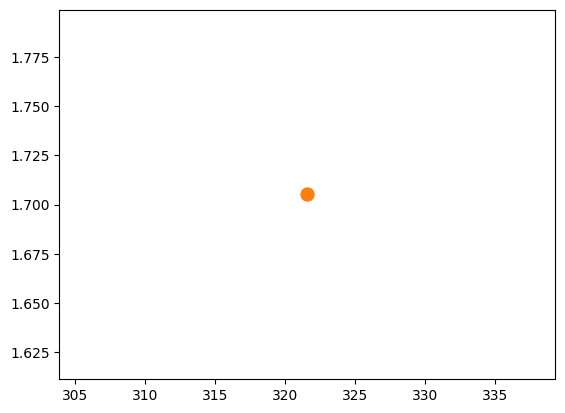

We match 0 galaxies of the high-res catalog to galaxy number 100 in the low-res catalog
The total weight of the galaxies is 0.00 (high-res) and 87.00 (low res)


In [57]:
pix_target = 100
elreso = 3
elreso2 = 5

_lower = ngalshifts_3d[elreso*8+elreso2-1]
_s = ngalshifts_1d[elreso]+elreso
#ind_low = pixs_galind_bounds[ngalshifts_1d[elreso]+elreso+pix_target]
#ind_up = pixs_galind_bounds[ngalshifts_1d[elreso]+elreso+pix_target+1]
#inds_sel = pix_gals[ngalshifts_1d[elreso]+ind_low:ngalshifts_1d[elreso]+ind_up]
inds_sel = np.argwhere(pixmatcher[_lower:_lower+ngals[elreso]] == pix_target).flatten()
_ws1 = weights[ngalshifts_1d[elreso]:ngalshifts_1d[elreso+1]][inds_sel]
_ws2 = weights[ngalshifts_1d[elreso2]:ngalshifts_1d[elreso2+1]][pix_target]
plt.scatter(pos1s[ngalshifts_1d[elreso]:ngalshifts_1d[elreso+1]][inds_sel],
            pos2s[ngalshifts_1d[elreso]:ngalshifts_1d[elreso+1]][inds_sel],
            s=_ws1)
plt.scatter(pos1s[ngalshifts_1d[elreso2]:ngalshifts_1d[elreso2+1]][pix_target],
            pos2s[ngalshifts_1d[elreso2]:ngalshifts_1d[elreso2+1]][pix_target],
            s=weights[ngalshifts_1d[elreso2]:ngalshifts_1d[elreso2+1]][pix_target])    
plt.show()

print("We match %i galaxies of the high-res catalog to galaxy number %i in the low-res catalog"%(len(inds_sel),pix_target))
print("The total weight of the galaxies is %.2f (high-res) and %.2f (low res)"%(np.sum(_ws1),np.sum(_ws2)))

In [131]:
inds_sel

array([ 398,  399,  400,  401, 1145, 1146, 1147, 1148, 1889, 1890, 1891,
       1892, 2634, 2635, 2636, 2637])

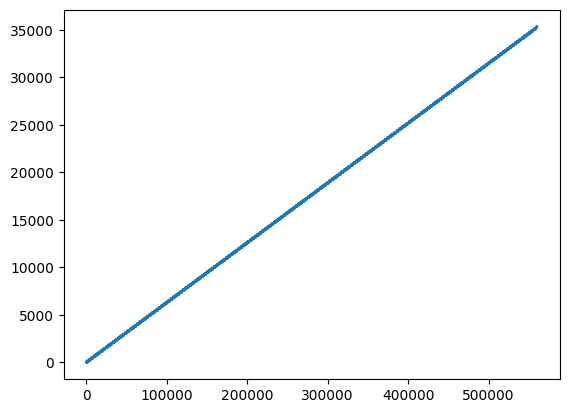

In [134]:
plt.plot(pixmatcher[_lower:_lower+ngals[elreso]])

In [39]:
len(index_matchers)/8

2704.0

In [42]:
index_matchers[1000:1100]

array([761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773,
       774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786,
       787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798,  -1,
        -1,  -1,  -1,  -1, 799, 800, 801, 802, 803, 804, 805, 806, 807,
       808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820,
       821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833,
       834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845,  -1,
        -1,  -1,  -1,  -1, 846, 847, 848, 849, 850], dtype=int32)

In [46]:
index_matchers[-200:]

array([2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130,
       2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141,
       2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152,
       2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161,   -1,   -1,
         -1,   -1,   -1, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2169,
       2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2180,
       2181, 2182, 2183, 2184, 2185, 2186, 2187, 2188, 2189, 2190, 2191,
       2192, 2193, 2194, 2195, 2196, 2197, 2198, 2199, 2200, 2201, 2202,
       2203, 2204, 2205, 2206, 2207, 2208,   -1,   -1,   -1,   -1,   -1,
         -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
         -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
         -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
         -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
         -1,   -1,   -1,   -1,   -1,   -1,   -1,   

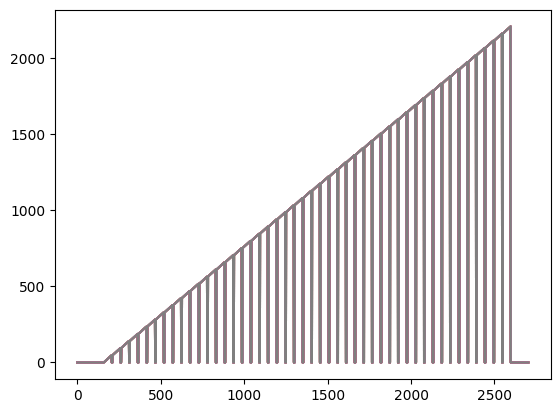

In [54]:
for i in range(8):
    plt.plot(index_matchers[i*2704:(i+1)*2704])

In [623]:
_ = slicsfullreso.multihash(dpixs,tomo=True)
ngals, pos1s, pos2s, weights, zbins, allfields, index_matchers, pixs_galind_bounds, pix_gals, dpixs1_true, dpixs2_true = _

In [624]:
ngals

[3070801, 2978077, 2722944, 1982942, 879640, 278659, 77403]

In [617]:
ngals

[3070801, 2794476, 2143411, 953190, 249999, 62500, 15625]

In [632]:
len(zbins[3])

1982942

In [633]:
slicsfullreso.zbins

array([0, 0, 0, ..., 1, 1, 1])

In [637]:
np.argwhere(slicsfullreso.zbins==4).flatten()

array([  12030,   12040,   13394, ..., 3025101, 3025102, 3025247])

In [11]:
_ = slicsfullreso.genmatched_multiresocats(dpixs,flattened=False)
ngals, pos1s, pos2s, weights, zbins, allfields, \
index_matchers, pixs_galind_bounds, pix_gals, resos1, resos2, pixmatcher = _

0 0 1 0
0 0 2 0
0 0 3 0
0 0 4 0
0 0 5 0
0 0 6 0
0 1 2 0
0 1 3 0
0 1 4 0
0 1 5 0
0 1 6 0
0 2 3 0
0 2 4 0
0 2 5 0
0 2 6 0
0 3 4 0
0 3 5 0
0 3 6 0
0 4 5 0
0 4 6 0
0 5 6 0
1 0 1 0
1 0 2 0
1 0 3 0
1 0 4 0
1 0 5 0
1 0 6 0
1 1 2 0
1 1 3 0
1 1 4 0
1 1 5 0
1 1 6 0
1 2 3 0
1 2 4 0
1 2 5 0
1 2 6 0
1 3 4 0
1 3 5 0
1 3 6 0
1 4 5 0
1 4 6 0
1 5 6 0


In [12]:
np.min(pixmatcher[1][0][0])

1702829

In [16]:
pixmatcher[0]

[[array([  67830,  687054, 1528161, ...,  121567,  939307,  445668],
        dtype=int32),
  array([  50501,  515654, 1145359, ...,   91394,  703984,  334736],
        dtype=int32),
  array([ 21171, 219085, 487056, ...,  38447, 299003, 142122], dtype=int32),
  array([  5344,  56874, 126305, ...,   9783,  77253,  36899], dtype=int32),
  array([ 1363, 14224, 31736, ...,  2460, 19365,  9286], dtype=int32),
  array([ 305, 3540, 7972, ...,  572, 4794, 2293], dtype=int32)],
 [array([      1,       2,       3, ..., 1276734, 1276735, 1276736],
        dtype=int32),
  array([     1,      1,      2, ..., 542922, 542923, 542924], dtype=int32),
  array([     0,      0,      1, ..., 140622, 140622, 140623], dtype=int32),
  array([    0,     0,     0, ..., 35342, 35342, 35342], dtype=int32),
  array([   0,    0,    0, ..., 8835, 8835, 8835], dtype=int32)],
 [array([     0,      1,      1, ..., 542923, 542924, 542927], dtype=int32),
  array([     0,      0,      0, ..., 140622, 140623, 140624], dtype

In [19]:
np.min(pixmatcher[1][1][1])

542928

In [56]:
np.max(pixmatcher[0][0][0])

1214549

In [58]:
nresos

NameError: name 'nresos' is not defined

In [69]:
nresos = len(zbins)
nbinsz = np.max(zbins[0])+1
ngals_zreso = np.zeros((nbinsz,nresos), dtype=np.int32)
for elbinz in range(nbinsz):
    for elreso in range(nresos):
        ngals_zreso[elbinz][elreso] = np.sum(zbins[elreso]==elbinz)

In [70]:
ngals_zreso

array([[1302897, 1214550,  994307,  514996,  143627,   36100,    9025],
       [1007974,  954540,  816083,  475266,  143514,   36100,    9025],
       [ 549302,  533048,  488288,  353468,  140452,   36100,    9025],
       [ 163166,  161783,  157556,  142015,   97517,   35685,    9025],
       [  47462,   47341,   46960,   45553,   40359,   26353,    8971]],
      dtype=int32)

In [74]:
_tmpshift = 0
ngalshifts_2d = -1*np.ones((nresos-1, nresos), dtype=np.int32)
for elreso in range(nresos-1):
    ngalshifts_2d[elreso][elreso] = _tmpshift
    for elreso2 in range(elreso+1,nresos):
        _tmpshift += ngals[elreso]
        ngalshifts_2d[elreso][elreso2] = _tmpshift
ngalshifts_2d

array([[       0,  3070801,  6141602,  9212403, 12283204, 15354005,
        18424806],
       [      -1, 18424806, 21336068, 24247330, 27158592, 30069854,
        32981116],
       [      -1,       -1, 32981116, 35484310, 37987504, 40490698,
        42993892],
       [      -1,       -1,       -1, 42993892, 44525190, 46056488,
        47587786],
       [      -1,       -1,       -1,       -1, 47587786, 48153255,
        48718724],
       [      -1,       -1,       -1,       -1,       -1, 48718724,
        48889062]], dtype=int32)

In [76]:
_tmpshift = 0
ngalshifts_3d = -1*np.ones((nbinsz, nresos-1, nresos), dtype=np.int32)
for elbinz in range(nbinsz):
    for elreso in range(nresos-1):
        ngalshifts_3d[elbinz][elreso][elreso] = _tmpshift
        for elreso2 in range(elreso+1,nresos):
            _tmpshift += ngals_zreso[elbinz][elreso]
            ngalshifts_3d[elbinz][elreso][elreso2] = _tmpshift
ngalshifts_3d

array([[[       0,  1302897,  2605794,  3908691,  5211588,  6514485,
          7817382],
        [      -1,  7817382,  9031932, 10246482, 11461032, 12675582,
         13890132],
        [      -1,       -1, 13890132, 14884439, 15878746, 16873053,
         17867360],
        [      -1,       -1,       -1, 17867360, 18382356, 18897352,
         19412348],
        [      -1,       -1,       -1,       -1, 19412348, 19555975,
         19699602],
        [      -1,       -1,       -1,       -1,       -1, 19699602,
         19735702]],

       [[19735702, 20743676, 21751650, 22759624, 23767598, 24775572,
         25783546],
        [      -1, 25783546, 26738086, 27692626, 28647166, 29601706,
         30556246],
        [      -1,       -1, 30556246, 31372329, 32188412, 33004495,
         33820578],
        [      -1,       -1,       -1, 33820578, 34295844, 34771110,
         35246376],
        [      -1,       -1,       -1,       -1, 35246376, 35389890,
         35533404],
        [      -1, 

In [76]:
dpixs = [0.5, 1.0, 2.0, 4.0, 8.0]
_res = slicsfullreso.multihash(dpixs, dpix_hash=dpixs[-1], extent=[-12,601,0,605])
ngals, pos1s, pos2s, weights, zbins, allfields, index_matchers, pixs_galind_bounds, pix_gals, dpixs1_true, dpixs2_true = _res

First spatialhash
Doing reso 0
Done reso 0
Doing reso 1
Done reso 1
Doing reso 2
Done reso 2
Doing reso 3
Done reso 3
Doing reso 4
Done reso 4


In [77]:
ngals

[3070801, 2419443, 1374773, 445830, 114001, 28880]

987172 987721 549
777623 778061 438
441921 442159 238
143255 143334 79
36608 36628 20
9215 9220 5


Text(0, 0.5, 'y [arcmin]')

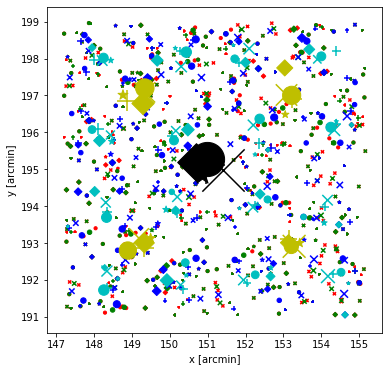

In [78]:
elregion = 1843
nresos = len(dpixs)+1

fig, ax = plt.subplots(figsize=(6,6))
for elreso in range(nresos):
    _lo, _up = pixs_galind_bounds[elreso][elregion], pixs_galind_bounds[elreso][elregion+1]
    print(_lo, _up, _up-_lo)
    galinds = pix_gals[elreso][_lo:_up]
    for elbinz in range(slicsfullreso.nbinsz):
        thisgalinds = galinds[zbins[elreso][galinds] == elbinz]
        ax.scatter(pos1s[elreso][thisgalinds], pos2s[elreso][thisgalinds],
                    color="rgbcykk"[elreso], marker="ox+D*"[elbinz], s=10*weights[elreso][thisgalinds])
ax.set_xlabel("x [arcmin]")
ax.set_ylabel("y [arcmin]")

In [79]:
slicsfullreso.index_matcher
np.sum(index_matchers[-1]-slicsfullreso.index_matcher)

0

In [99]:
# Setup all shift variables
hasdiscrete = True
nresos_grid = (nresos-hasdiscrete)
startreso_grid = int(hasdiscrete)


matchers_resoshift = np.zeros(nresos_grid+1, dtype=int)
ngal_in_pix = np.zeros(nresos*slicsfullreso.nbinsz, dtype=int)
for elreso in range(nresos):
    elreso_grid = elreso - hasdiscrete
    _lo, _up = pixs_galind_bounds[elreso][elregion], pixs_galind_bounds[elreso][elregion+1]
    galinds = pix_gals[elreso][_lo:_up]
    for elz in range(slicsfullreso.nbinsz):
        ngal_in_pix[elz*nresos+elreso] = np.sum(zbins[elreso][galinds] == elz)
        print(elreso_grid, elreso, elz, np.sum(zbins[elreso][galinds] == elz),  4**(nresos_grid-elreso_grid-1))
    if elreso_grid>=0:
        matchers_resoshift[elreso_grid+1] = matchers_resoshift[elreso_grid] +  4**(nresos_grid-elreso_grid-1)
len_matcher = matchers_resoshift[-1]

## Build the matcher
# * pix2redpix_checksum: 
#   --> Checker that all works --> Should have max of 1 and np.sum(pix2redpix_checksum)==np.sum(ngal_in_pix)
# * pix2redpix: 
#   --> Matches pixel index of full pixelgrid of region to the number of galaxy i sitting in the pixel
index_matcher_flat = np.argwhere(slicsfullreso.index_matcher>-1).flatten()
elregion_hash = index_matcher_flat[elregion]
elhashpix_start1 = slicsfullreso.pix1_start + (elregion_hash%slicsfullreso.pix1_n)*slicsfullreso.pix1_d
elhashpix_start2 = slicsfullreso.pix2_start + (elregion_hash//slicsfullreso.pix1_n)*slicsfullreso.pix2_d
pix2redpix = np.zeros(slicsfullreso.nbinsz*len_matcher, dtype=int)
pix2redpix_checksum = np.zeros(slicsfullreso.nbinsz*len_matcher, dtype=int)
pixmatcher = np.zeros(slicsfullreso.nbinsz*len_matcher*nresos_grid, dtype=int)
pixmatcher_3d = np.zeros((slicsfullreso.nbinsz, len_matcher, nresos_grid), dtype=int)
_tmpinds = np.zeros(slicsfullreso.nbinsz*nresos_grid, dtype=int)
for elreso in range(nresos_grid):
    thisreso = elreso + hasdiscrete
    _lo, _up = pixs_galind_bounds[thisreso][elregion], pixs_galind_bounds[thisreso][elregion+1]
    galinds = pix_gals[thisreso][_lo:_up]
    npix_side = 2**(nresos_grid-elreso-1)
    print(_up-_lo, npix_side)
    for elgalind in range(_up-_lo):
        thisgalind = pix_gals[thisreso][_lo+elgalind]
        thisgalz = zbins[thisreso][thisgalind]
        elhashpix_1 = int(np.floor((pos1s[thisreso][thisgalind]- elhashpix_start1)/dpixs1_true[elreso]))
        elhashpix_2 = int(np.floor((pos2s[thisreso][thisgalind]- elhashpix_start2)/dpixs2_true[elreso]))
        elhashpix = elhashpix_2*npix_side + elhashpix_1
        _tmpinds[thisgalz*nresos_grid+elreso] += 1
        pix2redpix[thisgalz*len_matcher+matchers_resoshift[elreso]+elhashpix] = elgalind
        pix2redpix_checksum[thisgalz*len_matcher+matchers_resoshift[elreso]+elhashpix] += 1

## Setup Gncache
nmax = 30
nbinstheta = 50
resoshift = ngal_in_pix[thisgalz*nresos+elreso]
thetashifts = np.zeros(slicsfullreso.nbinsz, dtype=int)
zshifts =  np.zeros(slicsfullreso.nbinsz, dtype=int)
for elz in range(slicsfullreso.nbinsz):
    for elreso in range(nresos):
        thetashifts[elz] += ngal_in_pix[elz*nresos+elreso]
    zshifts[elz] = nbinstheta * thetashifts[elz]
nshift = int(np.sum(zshifts))
Gncache = np.zeros((2*nmax+4)*nshift)



                        
    

"""        
# Not needed
for elreso in range(nresos_grid):
    thisreso = elreso + hasdiscrete
    _lo, _up = pixs_galind_bounds[thisreso][elregion], pixs_galind_bounds[thisreso][elregion+1]
    galinds = pix_gals[thisreso][_lo:_up]
    npix_side = 2**(nresos_grid-elreso-1)
    for elgalind in range(_up-_lo):
        thisgalind = pix_gals[thisreso][_lo+elgalind]
        thisgalz = zbins[thisreso][thisgalind]
        elhashpix_1 = int(np.floor((pos1s[thisreso][thisgalind]- elhashpix_start1)/dpixs1_true[elreso]))
        elhashpix_2 = int(np.floor((pos2s[thisreso][thisgalind]- elhashpix_start2)/dpixs2_true[elreso]))
        elhashpix = elhashpix_2*npix_side + elhashpix_1
        for lr_elreso in range(elreso+1, nresos_grid):
            lr_thisreso = lr_elreso + hasdiscrete
            lr_npix_side = 2**(nresos_grid-elreso2-1)
            lr_elhashpix_1 = int(np.floor((pos1s[thisreso][thisgalind]- elhashpix_start1)/dpixs1_true[lr_elreso]))
            lr_elhashpix_2 = int(np.floor((pos2s[thisreso][thisgalind]- elhashpix_start2)/dpixs2_true[lr_elreso]))
            lr_elhashpix = lr_elhashpix_2*lr_npix_side + lr_elhashpix_1
            lr_redpix = pix2redpix[thisgalz*len_matcher+matchers_resoshift[lr_elreso]+lr_elhashpix]
            pixmatcher[thisgalz*nresos_grid*len_matcher+(matchers_resoshift[elreso]+elhashpix)*nresos_grid+lr_elreso] = lr_redpix
            pixmatcher_3d[thisgalz,matchers_resoshift[elreso]+elhashpix,lr_elreso] = lr_redpix
"""

-1 0 0 117 1024
-1 0 1 179 1024
-1 0 2 146 1024
-1 0 3 71 1024
-1 0 4 36 1024
0 1 0 96 256
0 1 1 133 256
0 1 2 115 256
0 1 3 60 256
0 1 4 34 256
1 2 0 53 64
1 2 1 62 64
1 2 2 55 64
1 2 3 39 64
1 2 4 29 64
2 3 0 16 16
2 3 1 16 16
2 3 2 16 16
2 3 3 16 16
2 3 4 15 16
3 4 0 4 4
3 4 1 4 4
3 4 2 4 4
3 4 3 4 4
3 4 4 4 4
4 5 0 1 1
4 5 1 1 1
4 5 2 1 1
4 5 3 1 1
4 5 4 1 1
438 16
238 8
79 4
20 2
5 1


'        \n# Not needed\nfor elreso in range(nresos_grid):\n    thisreso = elreso + hasdiscrete\n    _lo, _up = pixs_galind_bounds[thisreso][elregion], pixs_galind_bounds[thisreso][elregion+1]\n    galinds = pix_gals[thisreso][_lo:_up]\n    npix_side = 2**(nresos_grid-elreso-1)\n    for elgalind in range(_up-_lo):\n        thisgalind = pix_gals[thisreso][_lo+elgalind]\n        thisgalz = zbins[thisreso][thisgalind]\n        elhashpix_1 = int(np.floor((pos1s[thisreso][thisgalind]- elhashpix_start1)/dpixs1_true[elreso]))\n        elhashpix_2 = int(np.floor((pos2s[thisreso][thisgalind]- elhashpix_start2)/dpixs2_true[elreso]))\n        elhashpix = elhashpix_2*npix_side + elhashpix_1\n        for lr_elreso in range(elreso+1, nresos_grid):\n            lr_thisreso = lr_elreso + hasdiscrete\n            lr_npix_side = 2**(nresos_grid-elreso2-1)\n            lr_elhashpix_1 = int(np.floor((pos1s[thisreso][thisgalind]- elhashpix_start1)/dpixs1_true[lr_elreso]))\n            lr_elhashpix_2 = int(

In [81]:
#### TEST ####
## Assign some galaxy to the Gncache
# This is just setup (which we already are given in .c)
elreso = 0
ngal_in_reso = 413
eln = 14
elthetas_test = [17,32]
eltheta = 43
reso_cuts = [0,20,25,30,35,40,50]
red_reso = max(0,elreso-hasdiscrete)
_lo, _up = pixs_galind_bounds[elreso][elregion], pixs_galind_bounds[elreso][elregion+1]
print(_up-_lo)
thisgalind = pix_gals[elreso][_lo+ngal_in_reso]
thisgalz = zbins[elreso][thisgalind]


## Now loop over the lower resolutions and do the assignment
npix_side = 2**(nresos_grid-red_reso-1)
elhashpix_1 = int(np.floor((pos1s[elreso][thisgalind]- elhashpix_start1)/dpixs1_true[red_reso]))
elhashpix_2 = int(np.floor((pos2s[elreso][thisgalind]- elhashpix_start2)/dpixs2_true[red_reso]))
elhashpix = elhashpix_2*npix_side + elhashpix_1
for lr_elreso in range(max(1,elreso),nresos):
    lr_red_reso = lr_elreso-hasdiscrete
    _dpix1 = dpixs1_true[lr_red_reso]
    _dpix2 = dpixs2_true[lr_red_reso]
    lr_npix_side = 2**(nresos_grid-lr_red_reso-1)
    lr_elhashpix_1 = int(np.floor((pos1s[elreso][thisgalind]- elhashpix_start1)/_dpix1))
    lr_elhashpix_2 = int(np.floor((pos2s[elreso][thisgalind]- elhashpix_start2)/_dpix2))
    lr_elhashpix = lr_elhashpix_2*lr_npix_side + lr_elhashpix_1
    lr_redpix = pix2redpix[thisgalz*len_matcher+matchers_resoshift[lr_red_reso]+lr_elhashpix]
    
    ind_Gncache = eln*nshift + zshifts[thisgalz] + eltheta*thetashifts[thisgalz] + lr_redpix
    Gncache[ind_Gncache] = elreso
    
    # Not needed (just check)
    _lo, _up = pixs_galind_bounds[lr_elreso][elregion], pixs_galind_bounds[lr_elreso][elregion+1]
    nextgalind = pix_gals[lr_elreso][_lo+lr_redpix]
    print(lr_elreso, lr_red_reso, lr_redpix, thisgalz, zbins[lr_elreso][nextgalind])

"""
## Finally, sum over the Gncache
gamma_0 = np.zeros(((2*nmax+1), slicsfullreso.nbinsz,slicsfullreso.nbinsz,slicsfullreso.nbinsz, nbinstheta, nbinstheta))
for eln in range(-nmax, nmax+1):
    for elbinz1 in range(slicsfullreso.nbinsz):
        for elbinz2 in range(slicsfullreso.nbinsz):
            for elbinz3 in range(slicsfullreso.nbinsz):
                tmpreso1 = 0
                tmpreso2 = 0
                tmpreso = 0
                for thetabin in elthetas_test:
                    if 
                    for thetabin in elthetas_test:
                        for elreso_cut, reso_cut in enumerate(reso_cuts):
                            if (reso_cut>)
                        gamma_0[eln+nmax] = 
"""

549
1 0 308 1 1
2 1 169 1 1
3 2 59 1 1
4 3 14 1 1
5 4 3 1 1


'\n## Finally, sum over the Gncache\ngamma_0 = np.zeros(((2*nmax+1), slicsfullreso.nbinsz,slicsfullreso.nbinsz,slicsfullreso.nbinsz, nbinstheta, nbinstheta))\nfor eln in range(-nmax, nmax+1):\n    for elbinz1 in range(slicsfullreso.nbinsz):\n        for elbinz2 in range(slicsfullreso.nbinsz):\n            for elbinz3 in range(slicsfullreso.nbinsz):\n                tmpreso1 = 0\n                tmpreso2 = 0\n                tmpreso = 0\n                for thetabin in elthetas_test:\n                    if \n                    for thetabin in elthetas_test:\n                        for elreso_cut, reso_cut in enumerate(reso_cuts):\n                            if (reso_cut>)\n                        gamma_0[eln+nmax] = \n'

[16  4  1]
0
3 2 64 0 0
4 3 16 0 0
5 4 4 0 0


Text(0, 0.5, 'y [arcmin]')

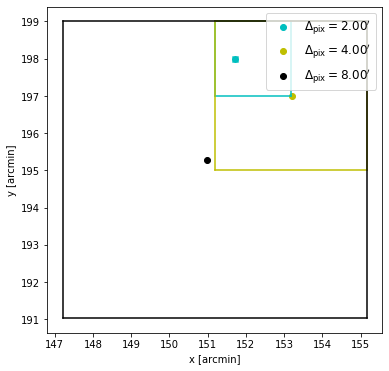

In [82]:
elreso = 3
ngal_in_reso = 64

red_reso = max(0,elreso-hasdiscrete)
_lo, _up = pixs_galind_bounds[elreso][elregion], pixs_galind_bounds[elreso][elregion+1]
print(ngal_in_pix[elreso:nresos])
thisgalind = pix_gals[elreso][_lo+ngal_in_reso]
thisgalz = zbins[elreso][thisgalind]

npix_side = 2**(nresos_grid-red_reso-1)
elhashpix_1 = int(np.floor((pos1s[elreso][thisgalind]- elhashpix_start1)/dpixs1_true[red_reso]))
elhashpix_2 = int(np.floor((pos2s[elreso][thisgalind]- elhashpix_start2)/dpixs2_true[red_reso]))
elhashpix = elhashpix_2*npix_side + elhashpix_1

color="rgbcyk"[elreso]
start_1pix = elhashpix_start1+elhashpix_1*dpixs1_true[red_reso]
start_2pix = elhashpix_start2+elhashpix_2*dpixs2_true[red_reso]
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter([pos1s[elreso][thisgalind]], [pos2s[elreso][thisgalind]], marker="x", color=color)
#ax.plot([start_1pix,start_1pix+dpixs1_true[red_reso]],[start_2pix,start_2pix], color=color)
#ax.plot([start_1pix,start_1pix+dpixs1_true[red_reso]],[start_2pix+dpixs2_true[red_reso],start_2pix+dpixs2_true[red_reso]], color=color)
#ax.plot([start_1pix,start_1pix],[start_2pix,start_2pix+dpixs2_true[red_reso]], color=color)
#ax.plot([start_1pix+dpixs1_true[red_reso],start_1pix+dpixs1_true[red_reso]],[start_2pix,start_2pix+dpixs2_true[red_reso]], color=color)

print(thisgalz)
matchedpos1s = []
matchedpos2s = []
for lr_elreso in range(max(1,elreso),nresos):
    lr_red_reso = lr_elreso-hasdiscrete
    _dpix1 = dpixs1_true[lr_red_reso]
    _dpix2 = dpixs2_true[lr_red_reso]
    lr_npix_side = 2**(nresos_grid-lr_red_reso-1)
    lr_elhashpix_1 = int(np.floor((pos1s[elreso][thisgalind]- elhashpix_start1)/_dpix1))
    lr_elhashpix_2 = int(np.floor((pos2s[elreso][thisgalind]- elhashpix_start2)/_dpix2))
    lr_elhashpix = lr_elhashpix_2*lr_npix_side + lr_elhashpix_1
    lr_redpix = pix2redpix[thisgalz*len_matcher+matchers_resoshift[lr_red_reso]+lr_elhashpix]
    _lo, _up = pixs_galind_bounds[lr_elreso][elregion], pixs_galind_bounds[lr_elreso][elregion+1]
    nextgalind = pix_gals[lr_elreso][_lo+lr_redpix]
    print(lr_elreso, lr_red_reso, lr_redpix, thisgalz, zbins[lr_elreso][nextgalind])
    matchedpos1s.append(pos1s[lr_elreso][nextgalind])
    matchedpos2s.append(pos2s[lr_elreso][nextgalind])
    color="rgbcyk"[lr_elreso]
    lr_start_1pix = elhashpix_start1+lr_elhashpix_1*_dpix1
    lr_start_2pix = elhashpix_start2+lr_elhashpix_2*_dpix2
    ax.scatter([pos1s[lr_elreso][nextgalind]], [pos2s[lr_elreso][nextgalind]], label=r"$\Delta_{\mathrm{pix}} = %.2f '$"%dpixs[lr_red_reso], 
               color=color)
    ax.plot([lr_start_1pix,lr_start_1pix+_dpix1],[lr_start_2pix,lr_start_2pix], color=color)
    ax.plot([lr_start_1pix,lr_start_1pix+_dpix1],[lr_start_2pix+_dpix2,lr_start_2pix+_dpix2], color=color)
    ax.plot([lr_start_1pix,lr_start_1pix],[lr_start_2pix,lr_start_2pix+_dpix2], color=color)
    ax.plot([lr_start_1pix+_dpix1,lr_start_1pix+_dpix1],[lr_start_2pix,lr_start_2pix+_dpix2], color=color)
ax.legend(loc="upper right", fontsize=12)
ax.set_xlabel("x [arcmin]")
ax.set_ylabel("y [arcmin]")

In [83]:
_u, _c = np.unique(pix2redpix, return_counts=True)
len(_u), np.sum(_c), len(pix2redpix)

(438, 1705, 1705)

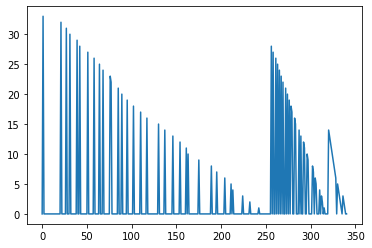

In [84]:
plt.plot(pix2redpix[(slicsfullreso.nbinsz-1)*len_matcher:(slicsfullreso.nbinsz-0)*len_matcher])

In [349]:
np.sum(pix2redpix!=0)

773

In [350]:
np.sum(pixmatcher!=0)

2420

In [229]:
print(ngal_in_pix)
print(np.sum(ngal_in_pix))

[ 96  50  16   4   1 121  59  16   4   1 113  56  16   4   1  55  42  16
   4   1  45  36  16   4   1]
778


In [351]:
_tmpinds

array([ 96,  50,  16,   4,   1, 121,  59,  16,   4,   1, 113,  56,  16,
         4,   1,  55,  42,  16,   4,   1,  45,  36,  16,   4,   1])

In [352]:
print(slicsfullreso.pix1_n, slicsfullreso.pix2_n)
print(slicsfullreso.pix1_d, slicsfullreso.pix2_d)
print(slicsfullreso.pix1_start, slicsfullreso.pix2_start)
print(slicsfullreso.pix1_start + (slicsfullreso.pix1_n)*slicsfullreso.pix1_d)
print(slicsfullreso.pix2_start + (slicsfullreso.pix2_n)*slicsfullreso.pix2_d)

79 78
7.962025316455696 7.961538461538462
-20.0 -8.0
609.0
613.0


In [290]:
index_matcher_flat = np.argwhere(slicsfullreso.index_matcher>-1).flatten()

In [291]:
dpixs2_true

array([0.49759615, 0.99519231, 1.99038462, 3.98076923, 7.96153846])

In [20]:
print(slicsfullreso.pix2_start + (slicsfullreso.pix2_n)*slicsfullreso.pix2_d)
slicsfullreso.pix1_start + (slicsfullreso.pix1_n)*slicsfullreso.pix1_d

613.0


609.0

In [254]:
slicsfullreso.pix1_d

7.962025316455696

In [46]:
print(elhashpix_start1, elhashpix_start2)

210.89873417721518 127.34615384615384


In [48]:
elhashpix

1388.5489428046972

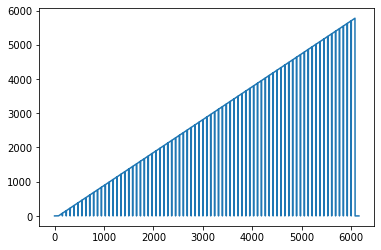

In [74]:
plt.plot(slicsfullreso.index_matcher)

In [300]:
dpixs1_true

array([0.49762658, 0.99525316, 1.99050633, 3.98101266, 7.96202532])

[0 0 0 0 0]
2 1 55
3 2 23
4 3 6
5 4 1


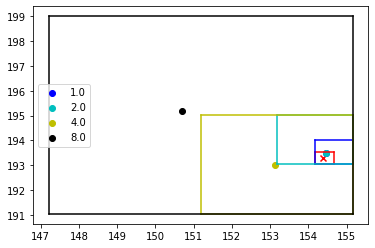

In [85]:
elreso = 0
ngal_in_reso = 217

red_reso = max(0,elreso-hasdiscrete)
_lo, _up = pixs_galind_bounds[elreso][elregion], pixs_galind_bounds[elreso][elregion+1]
thisgalind = pix_gals[elreso][_lo+ngal_in_reso]
thisgalz = zbins[elreso][thisgalind]

npix_side = 2**(nresos_grid-red_reso-1)
elhashpix_1 = int(np.floor((pos1s[elreso][thisgalind]- elhashpix_start1)/dpixs1_true[red_reso]))
elhashpix_2 = int(np.floor((pos2s[elreso][thisgalind]- elhashpix_start2)/dpixs2_true[red_reso]))
elhashpix = elhashpix_2*npix_side + elhashpix_1

color="rgbcyk"[elreso]
start_1pix = elhashpix_start1+elhashpix_1*dpixs1_true[red_reso]
start_2pix = elhashpix_start2+elhashpix_2*dpixs2_true[red_reso]
plt.scatter([pos1s[elreso][thisgalind]], [pos2s[elreso][thisgalind]], marker="x", color=color)
plt.plot([start_1pix,start_1pix+dpixs1_true[red_reso]],[start_2pix,start_2pix], color=color)
plt.plot([start_1pix,start_1pix+dpixs1_true[red_reso]],[start_2pix+dpixs2_true[red_reso],start_2pix+dpixs2_true[red_reso]], color=color)
plt.plot([start_1pix,start_1pix],[start_2pix,start_2pix+dpixs2_true[red_reso]], color=color)
plt.plot([start_1pix+dpixs1_true[red_reso],start_1pix+dpixs1_true[red_reso]],[start_2pix,start_2pix+dpixs2_true[red_reso]], color=color)

lr_matchedgals = pixmatcher_3d[thisgalz,matchers_resoshift[red_reso]+elhashpix]
print(lr_matchedgals)
matchedpos1s = []
matchedpos2s = []
for lr_elreso in range(elreso+1+(elreso==0),nresos):
    lr_red_reso = lr_elreso-hasdiscrete
    _dpix1 = dpixs1_true[lr_red_reso]
    _dpix2 = dpixs2_true[lr_red_reso]
    lr_npix_side = 2**(nresos_grid-lr_red_reso-1)
    lr_elhashpix_1 = int(np.floor((pos1s[elreso][thisgalind]- elhashpix_start1)/_dpix1))
    lr_elhashpix_2 = int(np.floor((pos2s[elreso][thisgalind]- elhashpix_start2)/_dpix2))
    lr_elhashpix = lr_elhashpix_2*lr_npix_side + lr_elhashpix_1
    lr_redpix = pix2redpix[thisgalz*len_matcher+matchers_resoshift[lr_red_reso]+lr_elhashpix]
    lr_start_1pix = elhashpix_start1+lr_elhashpix_1*_dpix1
    lr_start_2pix = elhashpix_start2+lr_elhashpix_2*_dpix2
    print(lr_elreso, lr_red_reso, lr_redpix)
    _lo, _up = pixs_galind_bounds[lr_elreso][elregion], pixs_galind_bounds[lr_elreso][elregion+1]
    nextgalind = pix_gals[lr_elreso][_lo+lr_redpix]
    matchedpos1s.append(pos1s[lr_elreso][nextgalind])
    matchedpos2s.append(pos2s[lr_elreso][nextgalind])
    color="rgbcyk"[lr_elreso]
    plt.scatter([pos1s[lr_elreso][nextgalind]], [pos2s[lr_elreso][nextgalind]], label=dpixs[lr_red_reso], color=color)
    plt.plot([lr_start_1pix,lr_start_1pix+_dpix1],[lr_start_2pix,lr_start_2pix], color=color)
    plt.plot([lr_start_1pix,lr_start_1pix+_dpix1],[lr_start_2pix+_dpix2,lr_start_2pix+_dpix2], color=color)
    plt.plot([lr_start_1pix,lr_start_1pix],[lr_start_2pix,lr_start_2pix+_dpix2], color=color)
    plt.plot([lr_start_1pix+_dpix1,lr_start_1pix+_dpix1],[lr_start_2pix,lr_start_2pix+_dpix2], color=color)
plt.legend()

In [278]:
nextgalind

array([96215, 96215, 73266, 73415, 96214], dtype=int32)

In [262]:
pixmatcher_3d.shape

(5, 341, 5)

In [265]:
matchers_resoshift

array([  0, 256, 320, 336, 340, 341])

In [267]:
matchers_resoshift[elreso]

256

In [329]:
lr_redpix

182

0 [  0 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201
 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219
 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237] 54
1 [  0 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157
 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175
 176 177 178 179 180 181 182 183 184] 63
2 [  0  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122] 56
3 [ 0 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67] 40
4 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28] 29


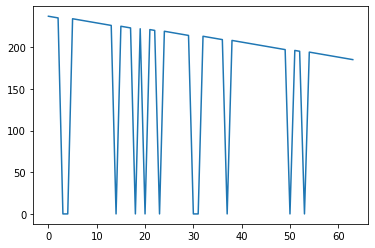

In [95]:
plt.plot(pix2redpix[256:320])
for i in range(5):
    print(i, np.unique(pix2redpix[i*341+256:i*341+320]), len(np.unique(pix2redpix[i*341+256:i*341+320])))


In [98]:
1 2 0 53 64
1 2 1 62 64
1 2 2 55 64
1 2 3 39 64
1 2 4 29 64

[3070801, 2419443, 1374773, 445830, 114001, 28880]

In [88]:
matchers_resoshift

array([  0, 256, 320, 336, 340, 341])

In [89]:
ngal_in_pix

array([117,  96,  53,  16,   4,   1, 179, 133,  62,  16,   4,   1, 146,
       115,  55,  16,   4,   1,  71,  60,  39,  16,   4,   1,  36,  34,
        29,  15,   4,   1])

In [1]:
import fftnpcf